In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = '/content/gdrive/My Drive/data/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    return image, image

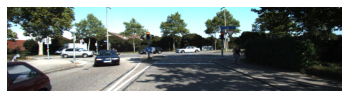

In [ ]:
image1, _ = load(PATH+'unet/kitti_train/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(image1/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(gray, color):
    gray  = (gray / 127.5) - 1
    color = (color / 127.5) - 1

    return gray, color

def random_jitter(gray, color):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        gray  = tf.image.flip_left_right(gray)
        color = tf.image.flip_left_right(color)

    return gray, color

def load_image_train(image_file):
    gray, color = load(image_file)
    gray, color = random_jitter(gray, color)
    gray, color = normalize(gray, color)

    return gray, color

def load_image_test(image_file):
    gray, color = load(image_file)
    gray, color = normalize(gray, color)

    return gray, color

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'unet/kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
for input, real in train_dataset:
  print(input.shape)
  print(real.shape)
  break

(1, 256, 1024, 3)
(1, 256, 1024, 3)


In [ ]:
def extract_first_features(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
for input, real in train_dataset:
  print(input.shape) # (1, 256, 1024, 3)

  x = downsample(64, 4)(input)
  print(x.shape)

  x = upsample(64, 4)(input)
  print(x.shape)

  break

(1, 256, 1024, 3)
(1, 128, 512, 64)
(1, 512, 2048, 64)


In [ ]:
def UNet_process(x): # (1, 256, 1024, 3) -> (1, 256, 1024, 64)
    down_stack = [
        downsample(64, 4),  # (bs, 128, 512, 64)
        downsample(256, 4), # (bs, 64, 256, 256)
        downsample(512, 4), # (bs, 32, 128, 512)
        downsample(512, 4), # (bs, 16, 64, 512)
        downsample(512, 4), # (bs, 8, 32, 512)
    ]

    up_stack = [
        upsample(512, 4), # (bs, 16, 64, 512)
        upsample(512, 4), # (bs, 32, 128, 512)
        upsample(256, 4), # (bs, 64, 256, 256)
        upsample(64, 4),  # (bs, 128, 512, 64)
    ]

    '''initializer = tf.random_normal_initializer(0., 0.02)
    OUTPUT_CHANNELS = 3
    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 1024, 3)

    concat = tf.keras.layers.Concatenate()'''
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    
    return x
    
def Generator(): 
    # multiple inputs
    inputs = tf.keras.layers.Input(shape=[256, 1024, 3])    
    x = inputs

    # extract_first_features
    fextract = extract_first_features(64, 3)  # (1, 256, 1024, 64)
    x = fextract(x) # (1,256,1024,64)
       
    # UNet_process
    fake_color = UNet_process(x)

    return tf.keras.Model(inputs=[inputs], outputs=[fake_color])

In [ ]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 1024, 64 832         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 512, 64) 65792       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 256, 256) 263168      sequential_1[0][0]               
______________________________________________________________________________________________